Epoch 1/100
12/12 [==============================] - 0s 26ms/step - loss: 4.9112
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 3.8303
Epoch 3/100
12/12 [==============================] - 0s 26ms/step - loss: 3.3504
Epoch 4/100
12/12 [==============================] - 0s 26ms/step - loss: 3.0934
Epoch 5/100
12/12 [==============================] - 0s 25ms/step - loss: 2.8977
Epoch 6/100
12/12 [==============================] - 0s 25ms/step - loss: 2.7183
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 2.6086
Epoch 8/100
12/12 [==============================] - 0s 26ms/step - loss: 2.5140
Epoch 9/100
12/12 [==============================] - 0s 26ms/step - loss: 2.4481
Epoch 10/100
12/12 [==============================] - 0s 26ms/step - loss: 2.3623
Epoch 11/100
12/12 [==============================] - 0s 26ms/step - loss: 2.3048
Epoch 12/100
12/12 [==============================] - 0s 25ms/step - loss: 2.2579
Epoch 13/100
12/12 [=====

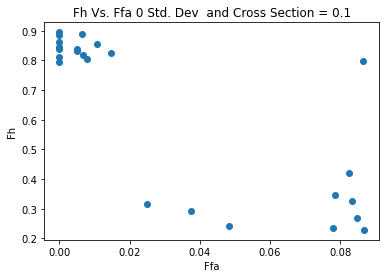

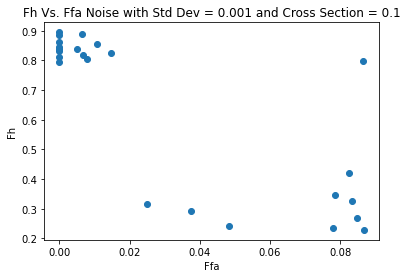

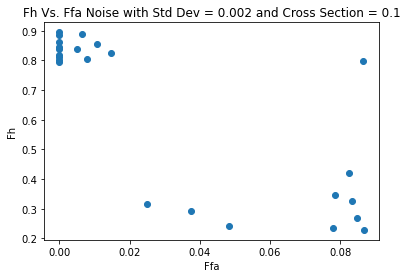

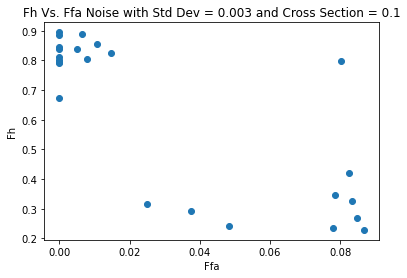

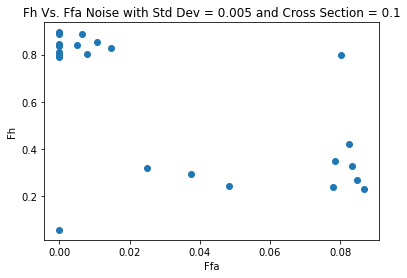

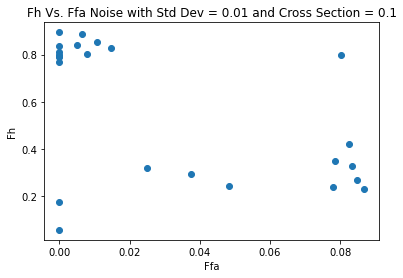

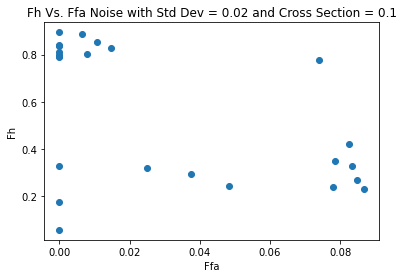

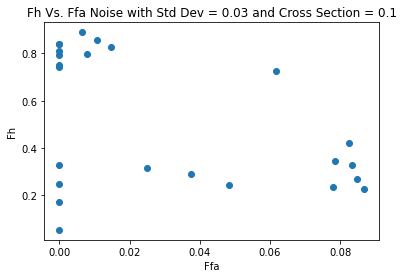

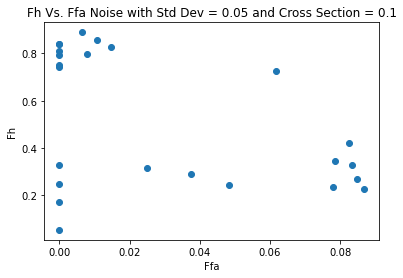

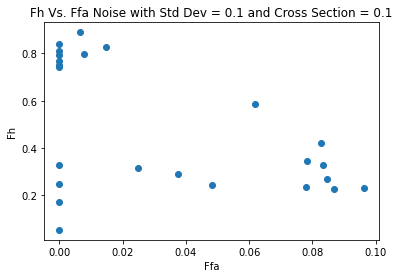

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 64.0x64.0 = 4096.0
Number of Weights in an Equivalent Single-Layer Perceptron = 64.0x64.0 = 4096.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 2621440
Number of Weights in Hidden Layer 2 = 655360
Number of Weights in Hidden Layer 3 = 196608
Number of Outputs = 16x16 = 256
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0     0.8     0.01        0.32         0.02        0.83         0.01        0.29         0.04        0.9             0    

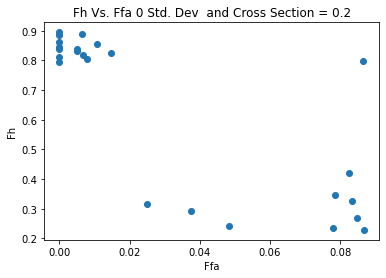

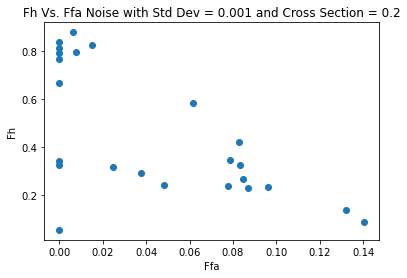

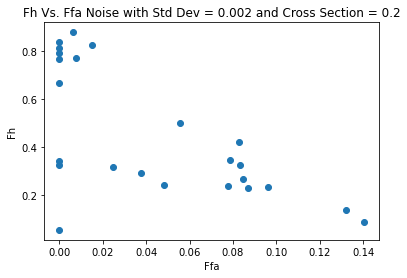

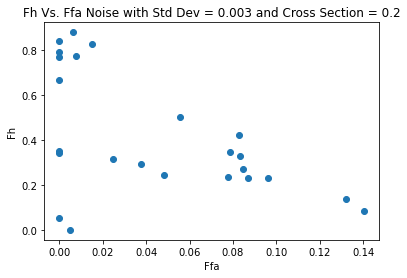

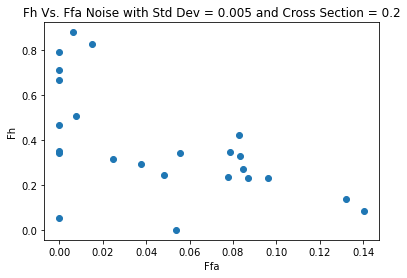

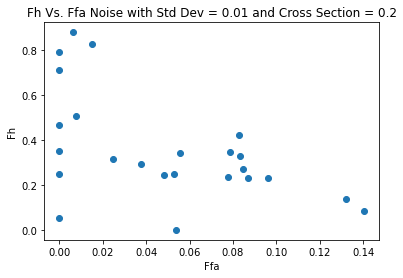

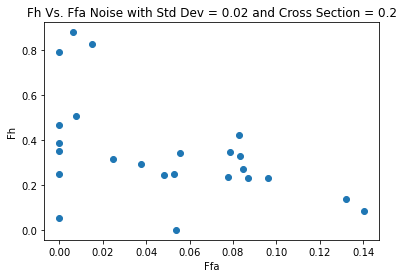

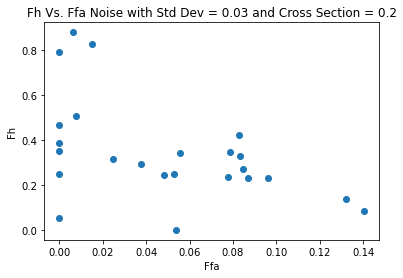

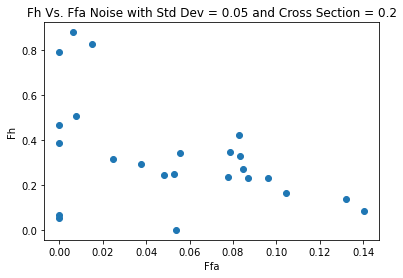

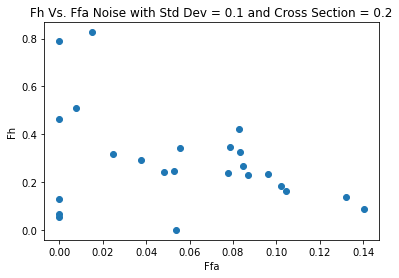

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 64.0x64.0 = 4096.0
Number of Weights in an Equivalent Single-Layer Perceptron = 64.0x64.0 = 4096.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 2621440
Number of Weights in Hidden Layer 2 = 655360
Number of Weights in Hidden Layer 3 = 196608
Number of Outputs = 16x16 = 256
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.8      0.01        0.32         0.02        0.83         0.01        0.29         0.04        0.9          0       

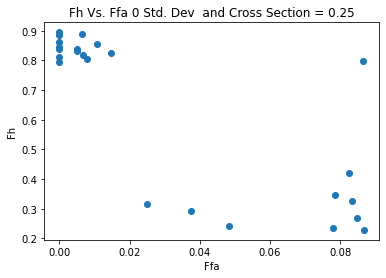

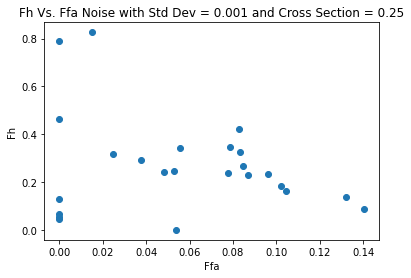

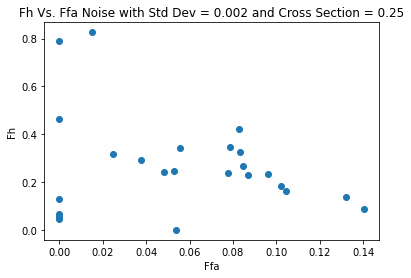

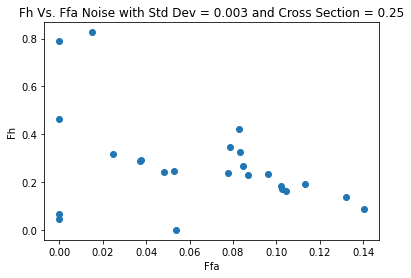

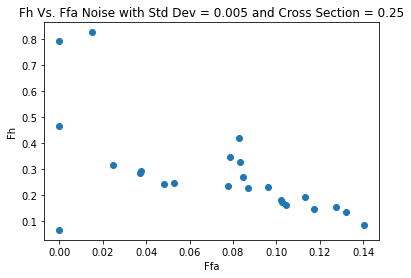

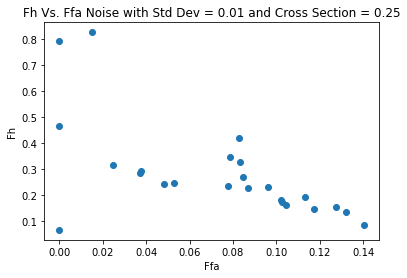

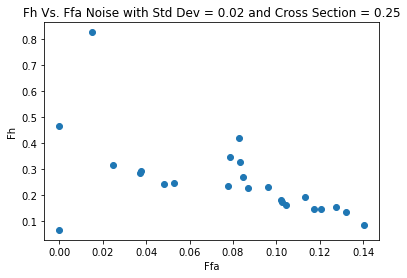

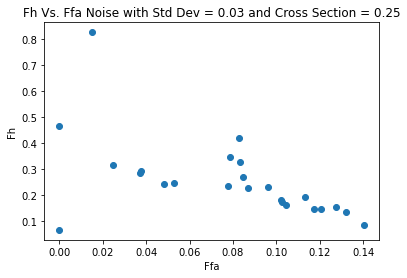

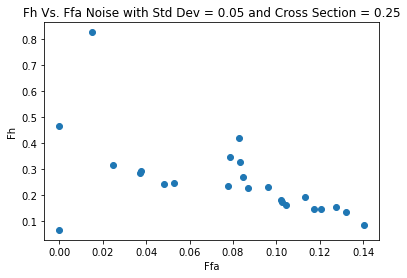

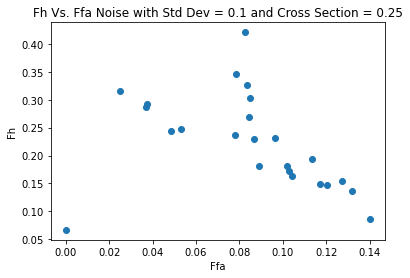

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 64.0x64.0 = 4096.0
Number of Weights in an Equivalent Single-Layer Perceptron = 64.0x64.0 = 4096.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 2621440
Number of Weights in Hidden Layer 2 = 655360
Number of Weights in Hidden Layer 3 = 196608
Number of Outputs = 16x16 = 256
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.8      0.01        0.32         0.02        0.83         0.01        0.29         0.04        0.9          0       

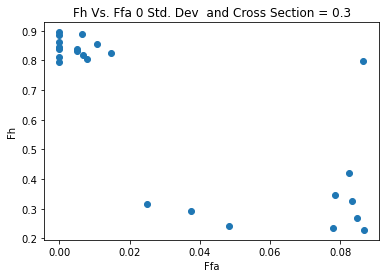

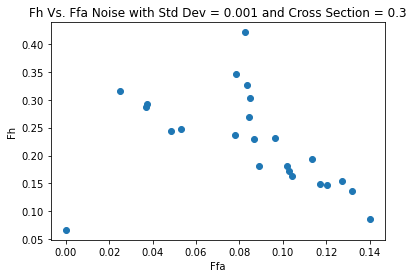

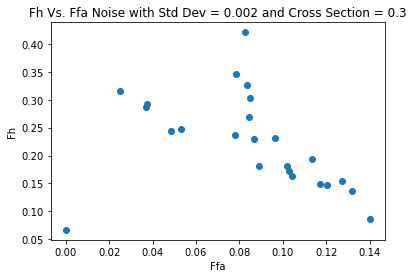

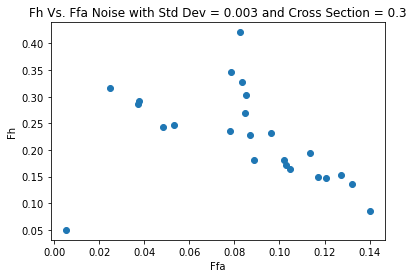

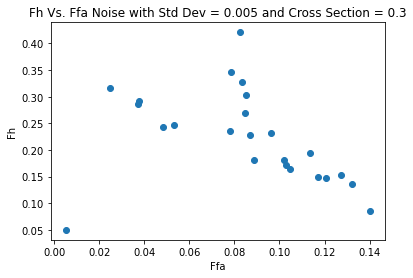

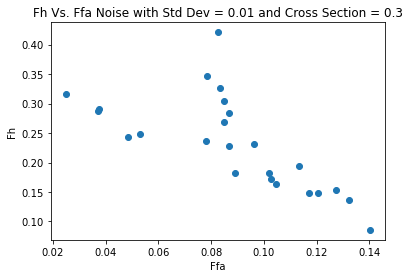

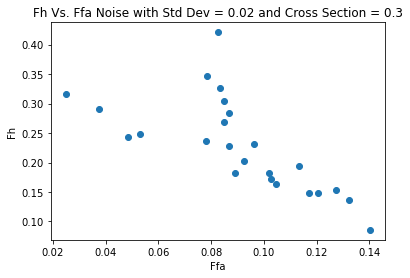

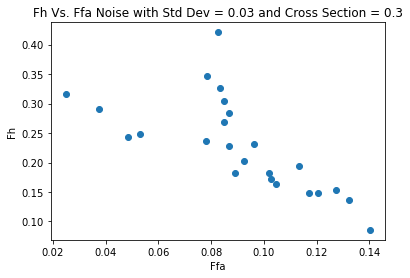

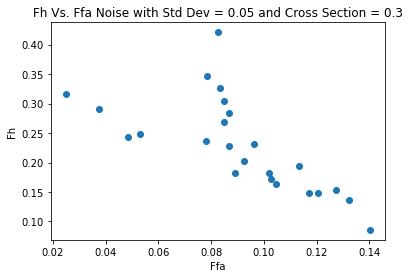

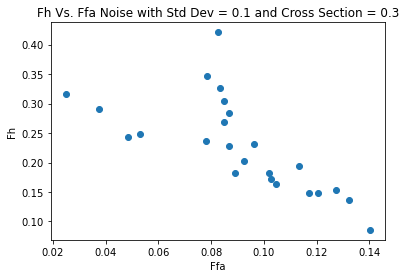

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 64.0x64.0 = 4096.0
Number of Weights in an Equivalent Single-Layer Perceptron = 64.0x64.0 = 4096.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 2621440
Number of Weights in Hidden Layer 2 = 655360
Number of Weights in Hidden Layer 3 = 196608
Number of Outputs = 16x16 = 256
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.8      0.01        0.32         0.02        0.83         0.01        0.29         0.04        0.9          0       

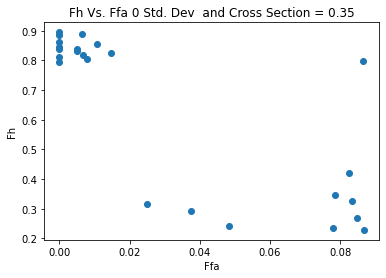

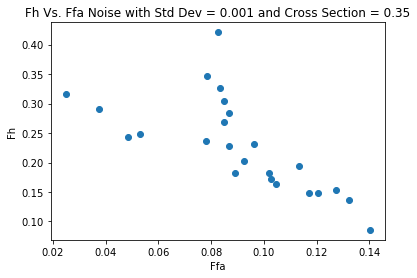

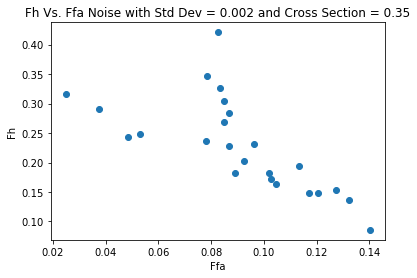

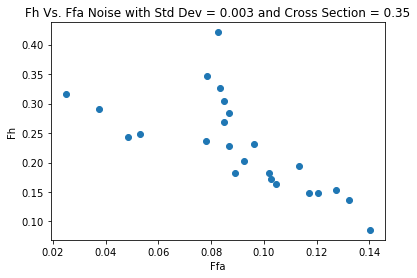

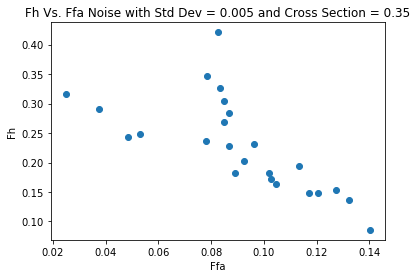

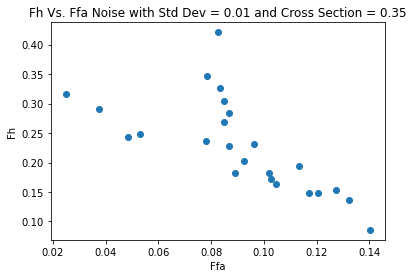

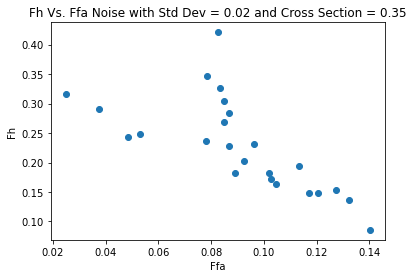

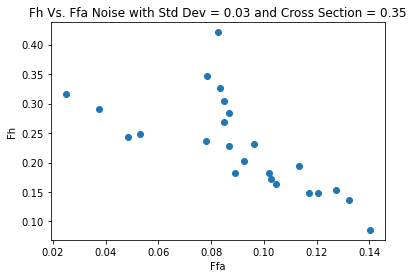

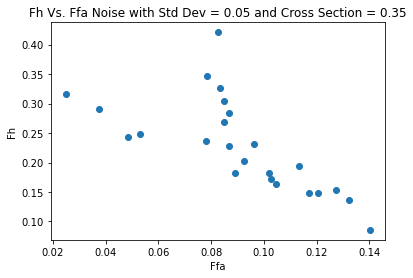

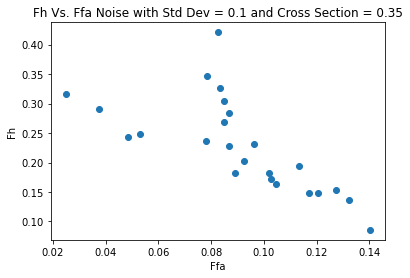

Table of Autoassociative Deep Neural Network Response to Noisy Input
Number of Inputs = 64.0x64.0 = 4096.0
Number of Weights in an Equivalent Single-Layer Perceptron = 64.0x64.0 = 4096.0K
Number of Hidden Layers in This DNN = 3
Number of Weights in Hidden Layer 1 = 2621440
Number of Weights in Hidden Layer 2 = 655360
Number of Weights in Hidden Layer 3 = 196608
Number of Outputs = 16x16 = 256
  Image    Fh 0    Ffa 0    Fh 0.001    Ffa 0.001    Fh 0.002    Ffa 0.002    Fh 0.003    Ffa 0.003    Fh 0.005    Ffa 0.005    Fh 0.01    Ffa 0.01    Fh 0.02    Ffa 0.02    Fh 0.03    Ffa 0.03    Fh 0.05    Ffa 0.05    Fh 0.1    Ffa 0.1
-------  ------  -------  ----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------  ---------  ----------  ---------  ----------  ---------  ----------  ---------  ----------  --------  ---------
      0    0.8      0.01        0.32         0.02        0.83         0.01        0.29         0.04        0.9          0       

C:\Users\Will\AppData\Local\Temp/ipykernel_16504/1712011083.py:323: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0, 0.1])


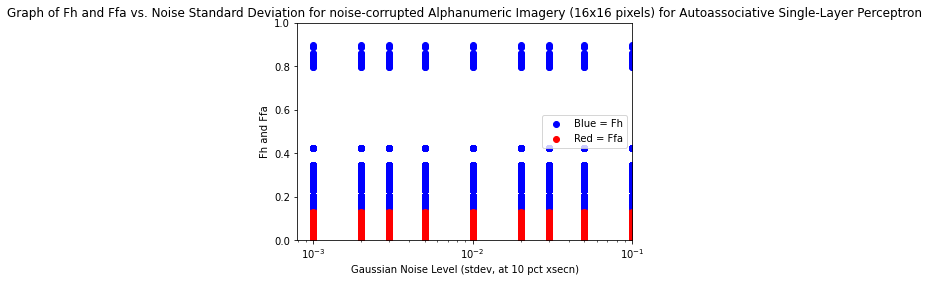

In [4]:
import cv2 
from math import *
import math
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import csv
import numpy
import random
from tabulate import tabulate

alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
            'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 
            'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
            'y', 'z', '0', '1', '2', '3', '4', '5',
            '6', '7', '8', '9']

alphabet2 = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
            'i', 'k', 'l', 'm', 'n', 'o', 'p', 
            'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
            'y']


def toBlackWhiteBinary(img):
    
    for i in range(len(img)):
        for j in range(len(img[i])):
            if img[i][j] < 128:
                img[i][j] = 0
                
            else:
                img[i][j] = 255
            
    
    return img

def makeBinaryImages():                
    for i in alphabet:
        path = list("./CharDataset1/x.jpg")
        path[len(path) - 5] = str(i)
        path = "".join(path)
        print(path, "\n")
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        print(type(img))
        img = toBlackWhiteBinary(img)
        cv2.imwrite(path, img)
        
def ImageToArray(img):
    final = []
    for i in range(len(img)):
        for j in range(len(img[1])):
            final.append(img[i][j])
            
    for i in range(len(final)):
        if final[i] == 255:
            final[i] = 1
        else:
            final[i] = 0
    return final

def compareImage(Original, Output):
    mismatch = 0
    for i in range(len(Original)):
        if Output[i] != Original[i]:
            mismatch += 1
    return mismatch / len(Original)

#gets all dataset images
def DataSetOfAllImages(num, size, alpha):
    dataset = []
    size = int(size / 16)
    
    if alpha == 2:
        for i in alphabet2:
            path = list("./CharDatasetx/y.jpg")
            if size != 4:
                path[len(path) - 5] = str(i)*size
            else:
                path[len(path) - 5] = str(i)

            path[13] = str(num)
            path = "".join(path)
            
            
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img.setflags(write = 1)
       
            dataset.append(ImageToArray(img))
        
        
    else:
        for i in alphabet:
            path = list("./CharDatasetx/y.jpg")
            path[len(path) - 5] = str(i)*size
            path[13] = str(num)
            path = "".join(path)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            img.setflags(write = 1)
       
            dataset.append(ImageToArray(img))
    
    
    return dataset



def Threshold(Arr):
    newArr = []
    for i in Arr:
        if i > 0.5:
            newArr.append(1)
        else:
            newArr.append(0)
    return newArr

def ThresholdResultArrays(arrs):
    newArr = []
    for i in arrs:
        newArr.append(Threshold(i))
    return newArr

def CountWhitePixels(img):
    count = 0
    for i in img:
        if i == 0:
            count += 1
    return count

def ComputeFh(correctImage, Output):
    TotalBlackPixels = 0
    TotalCorrectPixels = 0
    
    for i in range(len(correctImage)):
        if correctImage[i] == 1:
            TotalBlackPixels += 1
            if(Output[i] == 1):
                TotalCorrectPixels += 1
    
    if TotalBlackPixels == 0:
        TotalBlackPixels += 1
        
    return TotalCorrectPixels / TotalBlackPixels

def ComputeFhArray(correctImages, OutputImages):
    fhArr = []
    for i in range(len(correctImages)):
        fhArr.append(ComputeFh(correctImages[i], OutputImages[i]))
    return fhArr

def ComputeFfa(correctImage, Output):
    TotalWrongPixels = 0
    
    for i in range(len(correctImage)):
        if (Output[i] == 1) and (correctImage[i] != 1):
            TotalWrongPixels += 1
    
    if CountWhitePixels(correctImage) == 0:
        return TotalWrongPixels
    
    return TotalWrongPixels / CountWhitePixels(correctImage)

def ComputeFfaArray(correctImages, OutputImages):
    ffaArr = []
    for i in range(len(correctImages)):
        ffaArr.append(ComputeFfa(correctImages[i], OutputImages[i]))
    return ffaArr

#Images would be X
def Perturb(images, mean, std_dev, cs):
    
    NoiseCorruptedImages = []
    
    for i in images:
        currentImage = i
        
        mean, std_dev = mean, std_dev
        
        num = round(cs * len(i))

        sample = numpy.random.normal(mean, std_dev, num)
        

        RandomImageIndexes = random.sample(range(0, len(i)), num)
        
        sampleIndex = 0
        
        for j in RandomImageIndexes:
            currentImage[j] += sample[sampleIndex]
            sampleIndex += 1
        NoiseCorruptedImages.append(currentImage)
        
    return ThresholdResultArrays(NoiseCorruptedImages)
            
    
    
def Model(X, y):
    
    model = Sequential()
    model.add(Dense(256, input_dim = 256, activation='relu'))
    #model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=10, batch_size=2, verbose = True)
    return model

def MultiLayerModel(X, y):
    
    model = Sequential()
    model.add(Dense(128, input_dim = 256, activation='relu'))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=20, batch_size=2, verbose = True)
    return model

def SixteenAutoAssociativeDeepModel(X, y, _epochs, _batch_size, V = False):
    
    model = Sequential()
    
    model.add(Dense(128, input_dim = 256, activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=_epochs, batch_size=_batch_size, verbose = V)
    return model

def ThirtyTwoAutoAssociativeDeepModel(X, y, _epochs, _batch_size, V = False):
    
    model = Sequential()
    
    model.add(Dense(128, input_dim = 1024, activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    
    model.fit(X, y, epochs=_epochs, batch_size=_batch_size, verbose = V)
    return model

def SignLanguageModel(X, y, _epochs, _batch_size, V = False):
    
    model = Sequential()
    
    model.add(Dense(2048, input_dim = 4096, activation='relu'))
    model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam')
    model.fit(X, y, epochs=_epochs, batch_size=_batch_size, verbose = V)
    return model

#Dataset1, Prediction of DatasetOneUnderNoise
def RunAnalysis(X, Y, model, plotTitle=None):
    
    FhArray = ComputeFhArray(X, Y)
    FfaArray = ComputeFfaArray(X, Y)
    
    
    #print(FhArray)
    #print(FfaArray)
    
    plt.scatter(FfaArray, FhArray)
    plt.title(plotTitle)
    plt.xlabel("Ffa")
    plt.ylabel("Fh")
    plt.show()
    
    return [FhArray, FfaArray]

def Tabulate(FhArrays, FfaArrays, M, dim, num = 3):
    #(["Image 0",FhStdDev0, FfaStdDev0, ..., FhStdDev0.1, FfaStdDev0.1])
    table = []
    for i in range(10):
        newEntry = []
        newEntry.append(str(i))
        for j in range(len(FhArrays)):
            newEntry.append(str(round(FhArrays[i][j], 2)))
            newEntry.append(str(round(FfaArrays[i][j], 2)))
        table.append(newEntry)
        
    print("Table of Autoassociative Deep Neural Network Response to Noisy Input")
    print("Number of Inputs = " + str(dim) + "x" + str(dim) + " = " + str(dim * dim))
    print("Number of Weights in an Equivalent Single-Layer Perceptron = " + str(dim) + "x" + str(dim) + " = " + str(dim * dim) + "K")
    print("Number of Hidden Layers in This DNN = " + str(num))
    #print(M.layers[num - 1].output.shape[1])
    
    for i in range(num):
        print("Number of Weights in Hidden Layer " + str(i + 1) + " = " + str(M.layers[i].output.shape[1] * M.layers[i + 1].output.shape[1] + M.layers[i + 1].output.shape[1] * M.layers[i + 2].output.shape[1]))
        
    
    print("Number of Outputs = " + str(int(math.sqrt(M.layers[num + 1].output.shape[1]))) + "x" + str(int(math.sqrt(M.layers[num + 1].output.shape[1]))) + " = " + str(int(M.layers[num + 1].output.shape[1])))
    
    
    
    print(tabulate(table, headers = ["Image", "Fh 0", "Ffa 0", "Fh 0.001", "Ffa 0.001",
                                     "Fh 0.002", "Ffa 0.002", "Fh 0.003", "Ffa 0.003", 
                                     "Fh 0.005", "Ffa 0.005", "Fh 0.01", "Ffa 0.01", 
                                    "Fh 0.02", "Ffa 0.02", "Fh 0.03", "Ffa 0.03", 
                                     "Fh 0.05", "Ffa 0.05", "Fh 0.1", "Ffa 0.1"]))
    
def FinalPlot(FhArrays, FfaArrays, Std_Devs, pixels):
    
    for i in range(len(FhArrays)):
        for j in range(len(FhArrays[i])):
            for k in Std_Devs:
                plt.scatter(k, FhArrays[i][j], color='blue')
                plt.scatter(k, FfaArrays[i][j], color = 'red')
    plt.title("Graph of Fh and Ffa vs. Noise Standard Deviation for noise-corrupted Alphanumeric Imagery (" + str(pixels) + "x" + str(pixels) + " pixels) for Autoassociative Single-Layer Perceptron")
    
    plt.xscale('log')
    plt.xlabel("Gaussian Noise Level (stdev, at 10 pct xsecn)")
    plt.xlim([0, 0.1])
    #plt.xticks(numpy.arange(0, 0.1, 0.001))
    
    plt.ylim([0, 1])
    plt.ylabel("Fh and Ffa")
    
    plt.legend(["Blue = Fh", "Red = Ffa"])
    
    plt.show()
        
#64bitNonBinaryImages, Dataset1, Model, OutputPixels
def RunExperiment(X, ExpectedOutput, M, pixels):
    #print(X[1])
    print("Predicting Dataset")
    Y = ThresholdResultArrays(M.predict(X))
    print("Running Analysis")
    
    
    
    stdDevs = [0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1]
    cs = [0.1, 0.2, 0.25, 0.3, 0.35]
    
    
    print("Testing with Noise")
    
    
    for j in cs:
        a = RunAnalysis(ExpectedOutput, Y, M, "Fh Vs. Ffa 0 Std. Dev " + " and Cross Section = " + str(j))
        FhArrays = []
        FfaArrays = []
        FhArrays.append(a[0])
        FfaArrays.append(a[1])
        for i in stdDevs:
            NoisyImages = Perturb(X, 0, i, j)
            Z = ThresholdResultArrays(M.predict(NoisyImages))
            a = RunAnalysis(ExpectedOutput, Z, M, "Fh Vs. Ffa Noise with Std Dev = " + str(i) + " and Cross Section = " + str(j))
            FhArrays.append(a[0])
            FfaArrays.append(a[1])
            
        Tabulate(FhArrays, FfaArrays, M, math.sqrt(len(X[0])))
    
   
        
    
    stdDevs = [0] + stdDevs
    FinalPlot(FhArrays, FfaArrays, stdDevs, pixels)


    
def main():
                                #Dataset, Size, Alphabet
    X = numpy.array(DataSetOfAllImages(1, 16, 1))
    X2 = numpy.array(DataSetOfAllImages(2, 16, 1))
    X3 = numpy.array(DataSetOfAllImages(3, 64, 2))
    y = X
    y2 = numpy.array(DataSetOfAllImages(1, 16, 2))
    
    M =  SixteenAutoAssociativeDeepModel(X, y, 100, 2, True)
    #print("Running Experiment with Original Dataset")
    RunExperiment(X2, X, M, 32)
    #print("Running Experiment with Dataset #2")
    #RunExperiment(X2, M, 32)
    
    #M = SignLanguageModel(X3, y2, 25, 2, True)
    #print("Running Experiment with Sign Language Dataset")
    #RunExperiment(X3, y2, M, 16)
    
    
        
main()

        
        



